In [1]:
import os
from tqdm.notebook import tqdm
from random import shuffle
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np

import torch
import gsplat
from PIL import Image
from torch import optim
import torchvision.transforms as transforms

from src.model.gaussians import Gaussians
from src.data.colmap import ColmapDataSet

In [2]:
ROOT_DIR = '/media/jip/T7/thesis/code/data/'
if not os.path.isdir(ROOT_DIR):
    ROOT_DIR = '/home/jip/data1/'
ROOT_DIR += "bicycle"

DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
try:
    torch.cuda.set_device(DEVICE)
except:
    print("!WARNING! could not set cuda device, falling back to default")

In [3]:
def image_path_to_tensor(image_path:str):

    img = Image.open(image_path)
    transform = transforms.ToTensor()
    img_tensor = transform(img).permute(1, 2, 0)[..., :3]
    return img_tensor

def tensor_to_ndarray(image:torch.Tensor) -> np.ndarray:
    return image.detach().cpu().numpy()

def ndarray_to_Image(image:np.ndarray) -> Image.Image:
    return Image.fromarray((image*255).astype(np.uint8))

def tensor_to_Image(image:torch.Tensor) -> Image.Image:
    return ndarray_to_Image(tensor_to_ndarray(image))


def train(
    model:Gaussians,
    dataset:ColmapDataSet,
    device=DEVICE,
    num_epochs: int = 500,
    lr: float = 0.01
) -> tuple[Gaussians,dict]:

    # Set up optimizer
    optimizer = optim.Adam(
        model.parameters(), lr
    )
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
    loss_fn = torch.nn.MSELoss()

    # Output package
    out = {
        'losses':[],
        'lr':[]
    }

    # Use progress bar
    num_data = len(dataset)
    pbar = tqdm(total=num_epochs*num_data, desc="Training", smoothing=.5)

    save_every = 5
    save_at = '_DSC8680.JPG'
    # camera = dataset.cameras[1]
    # tensor_to_Image(camera.gt_image).save(f'renders/gt_{camera.name}')

    # Set up epoch
    epoch_loss=0.
    epoch_loss_norm=0
    idxs = []
    for epoch in range(1,num_epochs+1):
        idxs = list(range(num_data))
        shuffle(idxs)

        torch.cuda.empty_cache()

        for camera in dataset:

            # Forward pass
            camera.to(device)
            rendering = model.render(camera)
            loss = loss_fn(rendering, camera.gt_image)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if camera.name == save_at and epoch%save_every == 0:
                # tensor_to_Image(model.render(camera, bg=torch.zeros(3,device=device))).save(f'renders/epoch{epoch}_{camera.name}')
                tensor_to_Image(model.render(camera, bg=torch.zeros(3,device=device))).save(f'renders/latest_{camera.name}')

            # Update batch info
            epoch_loss += loss.item()
            epoch_loss_norm += 1

            # End iter
            camera.to('cpu')
            pbar.update()

        # Every 10 epochs for the first 60% of epochs decay lr
        if epoch%10==0 and epoch < .6*num_epochs:
            scheduler.step()

        # Compute epoch loss
        _loss = epoch_loss / epoch_loss_norm
        _lr = scheduler.get_last_lr()[0]

        out['losses'].append(_loss)
        out['lr'].append(_lr)
        epoch_loss_norm = 0.
        epoch_loss = 0

        pbar.set_postfix({
            'loss':f"{_loss:.2e}",
            'lr':f"{_lr:.1e}",
        })

    pbar.close()

    return model, out

In [4]:
dataset = ColmapDataSet(
    root_dir=ROOT_DIR,
    img_folder='images_4',
)

dataset.cameras = sorted(dataset.cameras, key=lambda cam:cam.name)[:10]

print(f"Found {len(dataset)} cameras")
assert len(dataset)>0,f"Could not find any cameras, root dir is {ROOT_DIR}"

Reading cameras...
Reading images...
Parsing cameras and images...
Found 10 cameras


In [5]:
model = Gaussians.from_colmap(
    path_to_points3D_file=os.path.join(ROOT_DIR,'sparse/0/points3D.txt'),
    device=DEVICE,
)
print(model.means.shape[0])

55933


Training:   0%|          | 0/5000 [00:00<?, ?it/s]

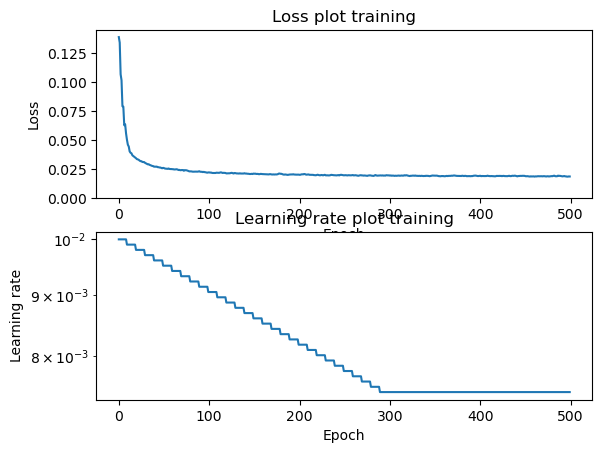

In [6]:
model,out = train(
    model,
    dataset,
    num_epochs=500,
    lr=0.01,
    device=DEVICE,
)
plt.subplot(2,1,1)
plt.plot(out['losses'])
plt.ylim(0)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss plot training")

plt.subplot(2,1,2)
plt.plot(out['lr'])
# plt.ylim(0)
plt.yscale('log')
plt.xlabel("Epoch")
plt.ylabel("Learning rate")
plt.title("Learning rate plot training")

plt.show()

In [7]:
print("Saving results..")
out_dir = os.path.join(os.getcwd(), "renders")

rendering = []
nrow = len(dataset)

cameras = sorted(dataset, key=lambda cam:cam.name)

for camera in cameras:

    camera.to(DEVICE)
    bg = torch.zeros(3,dtype=torch.float, device=DEVICE)

    I = ndarray_to_Image(np.hstack((
        tensor_to_ndarray(camera.gt_image),
        tensor_to_ndarray(model.render(camera, bg=bg))
    )))

    I.save(os.path.join(out_dir,camera.name))
    rendering.append(I)

rendering[0].save(
    os.path.join(out_dir,"rendering.gif"),
    save_all=True,
    append_images=rendering[2::2],
    optimize=False,
    duration=500,
    loop=0,
)

print("Results saved")

# os.makedirs(out_dir,exist_ok=True)

# for fname in out['frames']:
#     Image.fromarray(out['gt'][fname]).save(os.path.join(out_dir,fname))

#     frames = [Image.fromarray(frame) for frame in out['frames'][fname]]

#     frames[-1].save(os.path.join(out_dir,fname.split(".")[0]+"_final.png"))

Saving results..
tensor([[ 0.2348, -0.0313, -0.9715, -0.0232],
        [-0.0570,  0.9973, -0.0459, -1.0701],
        [ 0.9704,  0.0662,  0.2324,  3.8410],
        [ 0.0000,  0.0000,  0.0000,  1.0000]], device='cuda:0')
tensor([[ 0.2018, -0.0362, -0.9788, -0.1559],
        [ 0.2679,  0.9633,  0.0196, -0.0051],
        [ 0.9421, -0.2661,  0.2041,  4.1173],
        [ 0.0000,  0.0000,  0.0000,  1.0000]], device='cuda:0')
tensor([[ 3.3224e-03,  2.5117e-02, -9.9968e-01,  1.5676e-02],
        [ 3.6220e-02,  9.9903e-01,  2.5221e-02, -7.9817e-01],
        [ 9.9934e-01, -3.6293e-02,  2.4094e-03,  3.9025e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]], device='cuda:0')
tensor([[ 3.7627e-02, -1.3642e-02, -9.9920e-01,  1.9036e-01],
        [ 3.9201e-01,  9.1996e-01,  2.2019e-03,  5.1833e-01],
        [ 9.1919e-01, -3.9178e-01,  3.9963e-02,  4.0661e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]], device='cuda:0')
tensor([[-2.7442e-01,  1.7772e-03, -9.6161e-01,